In [1]:
import time
import pyvista as pv
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/mandart/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:

def saveimage(i):  
    X = df['X']
    Y = df['Y']
    Z = df['Z']
    Ux = df['Velocity_X_'+str(i)]
    Uy = df['Velocity_X_'+str(i)]
    Uz = df['Velocity_X_'+str(i)]

    # Compute velocity magnitude
    from scipy.interpolate import griddata
    velocity_magnitude = np.sqrt(Ux**2 + Uy**2 + Uz**2)

    # Define the plane where you want to plot the contour
    # For example, let's define a plane at z = 0
    xmin, xmax = np.min(X), np.max(X)
    ymin, ymax = np.min(Y), np.max(Y)
    x = np.linspace(xmin, xmax, 200) #Reduce division for coarse.
    y = np.linspace(ymin, ymax, 200)
    X_plane, Y_plane = np.meshgrid(x, y)
    #Z_plane = np.zeros_like(X_plane)  # z = 0 plane

    # Interpolate the velocity magnitude onto the plane
    velocity_magnitude_plane = griddata((X, Y), velocity_magnitude, (X_plane, Y_plane), method='linear')
    

    
    fig1, ax2 = plt.subplots()
    # Plot the contour plot of velocity magnitude on the plane
    sp=ax2.contourf(X_plane, Y_plane, velocity_magnitude_plane, cmap=cm.jet) #cm.jet viridis
    plt.title('Contour Plot of Velocity Magnitude')
    plt.gca().set_aspect('equal')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig1.colorbar(sp,label='Velocity Magnitude',cax=cax)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    
    
    
    
   
    plt.savefig(fn +'/'+str(i)+'_vel.png')
    plt.show()
    print(f"Image saved successfully")

#return ()
      

(542571, 101)
Turbine located at around Y=1500, X=1000 in figure below


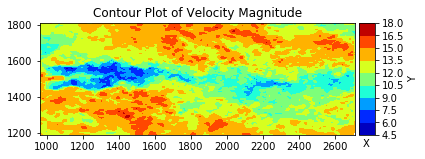

Image saved successfully


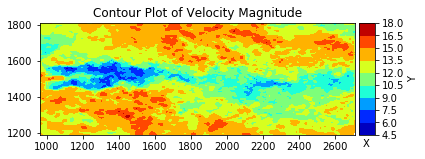

Image saved successfully


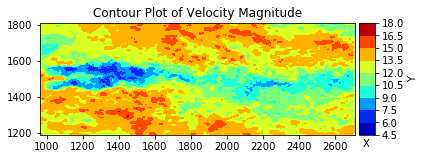

Image saved successfully
CSV file saved successfully: /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/Results_from_ROM/Output.csv
23.744030527


In [3]:
start = time.process_time()
 

# Step 1. Load POD basis functions and true coefficients
#- ---------------------------------------------------------------------------------------------------

fn=os.path.abspath("../Results_from_ROM")



data=np.load(fn+'/mat.npz') #460 MB size. #data contains - name1=Phit, name2=tm, name3=tcoeff, name4=U1, name5=U1_wo_mean)

Phi=data['name1'] #Basis function. (n_grid=542571 x n_modes=10)

tcoeff=data['name3'] #True temporal coefficient. (n_modes=10 x n_snapshot=101)

tm=data['name2']  #mean of velocity, m/s (needed for reconstruction) : a scalar array(2.31225, dtype=float32)

grid2=pv.UnstructuredGrid(fn+'/Utest.vtk')


# Step 2. Load LSTM model for obtaining temporal coefficient at interpolated time t.
#- ---------------------------------------------------------------------------------------------------
#LSTM will be needed only if you want to generate temporal coefficients at intermediate times 

lstm=False

if lstm==True:
    #avoid for now as needs initial inputs. You obtain these initial coefficients 
    #by projecting the past velocity field onto the basis functions.
    reconstructed_model = load_model(fn+"/best_model.h5")    
    #predicted_coef_scaled=reconstructed_model.predict(xvalid) #provide xvalid that has "lookback" previous temporal coefficients associated with all modes. a 3D array with n_sample=1 x lookback=3 x num_modes=10.
    #predicted_coef = sc.inverse_transform(predicted_coef_scaled) #Load the scaling
    #print(reconstructed_model.summary())
    #predicted_coef=lstm_coef
else: 
    predicted_coef=tcoeff


#Step 3. Reconstruct flow field from the basis modes, the mean and the computed coefficients
#- ---------------------------------------------------------------------------------------------------
velocity_recon=np.dot(Phi,np.array(predicted_coef))+tm #3*num_grid x num_timesteps 101

print(velocity_recon.shape) 
#Shape and size.




#Step 4: Save and Visualize reconstructed flow field.
#- ---------------------------------------------------------------------------------------------------

print("Turbine located at around Y=1500, X=1000 in figure below")
data = {'X': grid2.points[:, 0],    #cell_centers.points
        'Y': grid2.points[:, 1],
        'Z': grid2.points[:, 2],
       }
df = pd.DataFrame(data)

#Suggest Time for reconstruction in arange below. 
#To reconstruct at all time-steps and save images, start loop from 0.
for i in np.arange(velocity_recon.shape[1]-3,velocity_recon.shape[1]): #0,
    
    Ureconstructed=velocity_recon[:,i].reshape(-1, 3, order='F')
    
    grid2.point_data.set_vectors(Ureconstructed, "U_reconstructed_"+str(i))
    
    vel=grid2['U_reconstructed_'+str(i)]
    
    data2 = {'Velocity_X_'+str(i): vel[:, 0],  # Assuming velocity is a vector with X, Y, Z components
        'Velocity_Y_'+str(i): vel[:, 1],
        'Velocity_Z_'+str(i): vel[:, 2]}    
    
    
    
    df=df.join(pd.DataFrame(data2))   
    
    saveimage(i)

# Save CSV    
csv_file = fn+'/'+ 'Output.csv'     
df.to_csv(csv_file, index=False)
print(f"CSV file saved successfully: {csv_file}")

#Save Grid
grid2.save(fn+'/Velocity_reconstruction_stored.vtk')
grid2.save(fn+'/Velocity_reconstruction_stored.vtu') 
    
#Print time taken
print(time.process_time() - start)
